In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

Load Dataset from  [Stanford Earthquake Dataset (STEAD)](https://www.kaggle.com/datasets/isevilla/stanford-earthquake-dataset-stead/data/)

In [55]:
data = pd.read_csv(file_name, delimiter=',', on_bad_lines='skip', low_memory=False)
print(data.head())
print(data.columns)

  network_code receiver_code receiver_type  receiver_latitude  \
0           TA          109C            HH            32.8889   
1           TA          109C            HH            32.8889   
2           TA          109C            HH            32.8889   
3           TA          109C            HH            32.8889   
4           TA          109C            HH            32.8889   

   receiver_longitude  receiver_elevation_m  p_arrival_sample p_status  \
0           -117.1051                 150.0               NaN      NaN   
1           -117.1051                 150.0               NaN      NaN   
2           -117.1051                 150.0               NaN      NaN   
3           -117.1051                 150.0               NaN      NaN   
4           -117.1051                 150.0               NaN      NaN   

   p_weight  p_travel_sec  ...  source_magnitude_author  \
0       NaN           NaN  ...                      NaN   
1       NaN           NaN  ...                

Inspection and Cleaning

In [56]:
print(data.isnull().sum())
print(data.dtypes)

network_code                             44
receiver_code                             0
receiver_type                             0
receiver_latitude                         0
receiver_longitude                        0
receiver_elevation_m                      0
p_arrival_sample                     235426
p_status                             235426
p_weight                             235600
p_travel_sec                         235426
s_arrival_sample                     235426
s_status                             235426
s_weight                             235581
source_id                            235426
source_origin_time                   235426
source_origin_uncertainty_sec       1125363
source_latitude                      235426
source_longitude                     235426
source_error_sec                     806154
source_gap_deg                       884840
source_horizontal_uncertainty_km     824919
source_depth_km                      235475
source_depth_uncertainty_km     

Handling mising value

In [57]:
threshold = len(data) * 0.5
data = data.dropna(thresh=threshold, axis=1)
data = data.fillna(0)

In [58]:
print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265657 entries, 0 to 1265656
Data columns (total 28 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   network_code           1265657 non-null  object 
 1   receiver_code          1265657 non-null  object 
 2   receiver_type          1265657 non-null  object 
 3   receiver_latitude      1265657 non-null  float64
 4   receiver_longitude     1265657 non-null  float64
 5   receiver_elevation_m   1265657 non-null  float64
 6   p_arrival_sample       1265657 non-null  float64
 7   p_status               1265657 non-null  object 
 8   p_weight               1265657 non-null  float64
 9   p_travel_sec           1265657 non-null  float64
 10  s_arrival_sample       1265657 non-null  float64
 11  s_status               1265657 non-null  object 
 12  s_weight               1265657 non-null  float64
 13  source_id              1265657 non-null  object 
 14  source_origin_time

make column names equal

In [59]:
data.columns = data.columns.str.strip().str.lower()
print(data.columns)

Index(['network_code', 'receiver_code', 'receiver_type', 'receiver_latitude',
       'receiver_longitude', 'receiver_elevation_m', 'p_arrival_sample',
       'p_status', 'p_weight', 'p_travel_sec', 's_arrival_sample', 's_status',
       's_weight', 'source_id', 'source_origin_time', 'source_latitude',
       'source_longitude', 'source_depth_km', 'source_magnitude',
       'source_magnitude_type', 'source_distance_deg', 'source_distance_km',
       'back_azimuth_deg', 'snr_db', 'coda_end_sample', 'trace_start_time',
       'trace_category', 'trace_name'],
      dtype='object')


Encone the target column

In [60]:
if 'trace_category' in data.columns:
    print(data['trace_category'].unique())

    data['trace_category'] = data['trace_category'].fillna('unknown')

    label_encoder = LabelEncoder()
    data['trace_category'] = label_encoder.fit_transform(data['trace_category'])
    print(label_encoder.classes_)
else:
    print("Error: 'trace_category' column not found!")

['noise' 'earthquake_local']
['earthquake_local' 'noise']


Feature Selection and preprocessing

In [61]:
features = data[['p_arrival_sample', 's_arrival_sample', 'source_latitude',
                 'source_longitude', 'source_depth_km']]
target = data['trace_category']

features = features.apply(pd.to_numeric, errors='coerce')
features = features.fillna(0)

Scaling


In [62]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

split the test

In [63]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.3, random_state=42)


Train using Random forest classifier

In [64]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [65]:
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    309246
           1       1.00      1.00      1.00     70452

    accuracy                           1.00    379698
   macro avg       1.00      1.00      1.00    379698
weighted avg       1.00      1.00      1.00    379698

Confusion Matrix:
 [[309246      0]
 [     0  70452]]


Confusion Matrix

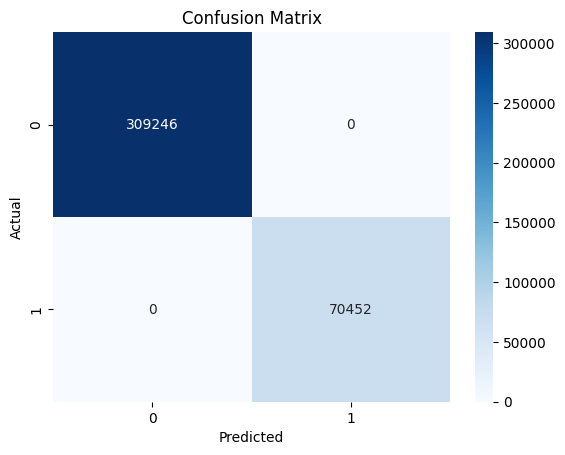

In [66]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

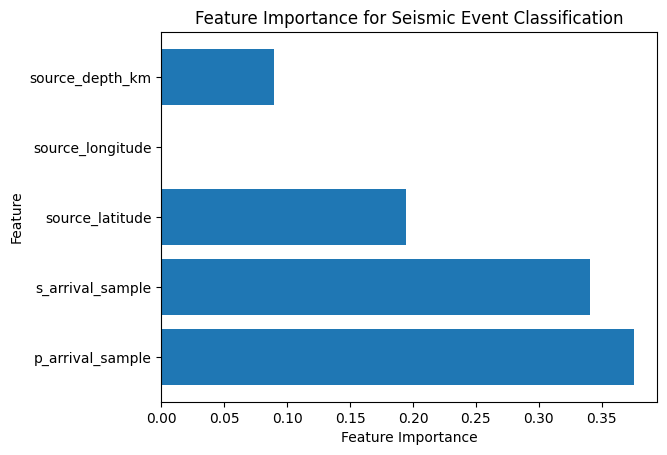

In [67]:
# Plot feature importance
importances = model.feature_importances_
plt.barh(features.columns, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Seismic Event Classification')
plt.show()

In [68]:
joblib.dump(model, 'seismic_model.pkl')

# from google.colab import files
# files.download('seismic_model.pkl')


['seismic_model.pkl']

In [69]:
test_data = pd.read_csv("new_test_data.csv")
print(test_data.head())

   p_arrival_sample  s_arrival_sample  source_latitude  source_longitude  \
0              1000              2000            32.88           -117.10   
1              2000              3000            33.01           -118.20   
2                 0                 0            32.90           -117.50   
3                 0                 0            32.85           -117.00   
4              1200              2400            33.22           -118.55   

   source_depth_km    trace_category  
0             10.0  earthquake_local  
1             20.0  earthquake_local  
2              0.0             noise  
3              0.0             noise  
4             12.5  earthquake_local  


In [70]:
test_features = test_data[['p_arrival_sample', 's_arrival_sample', 'source_latitude',
                           'source_longitude', 'source_depth_km']]
test_features = test_features.fillna(0)
test_features_scaled = scaler.transform(test_features)


In [71]:
model = joblib.load('seismic_model.pkl')

In [72]:
predictions = model.predict(test_features_scaled)
print(predictions)

[0 0 1 1 0 0 1 1 0 0]


In [73]:
class_names = label_encoder.inverse_transform(predictions)
print(class_names)

['earthquake_local' 'earthquake_local' 'noise' 'noise' 'earthquake_local'
 'earthquake_local' 'noise' 'noise' 'earthquake_local' 'earthquake_local']


In [74]:
test_data['predicted_trace_category'] = class_names
print(test_data[['predicted_trace_category']].head())

  predicted_trace_category
0         earthquake_local
1         earthquake_local
2                    noise
3                    noise
4         earthquake_local


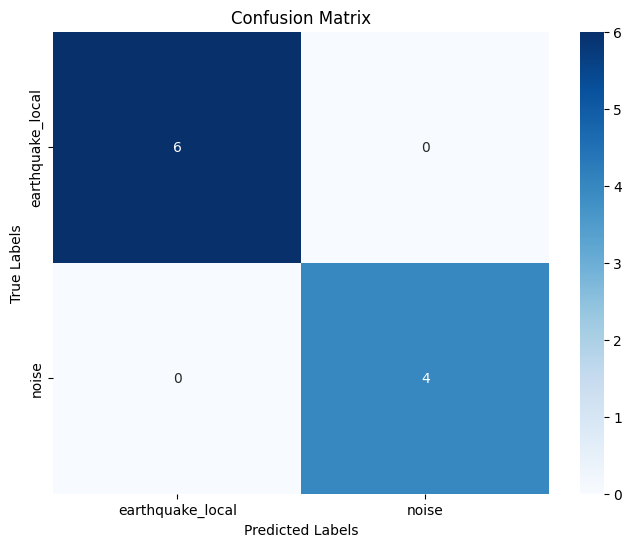

Classification Report:
                   precision    recall  f1-score   support

earthquake_local       1.00      1.00      1.00         6
           noise       1.00      1.00      1.00         4

        accuracy                           1.00        10
       macro avg       1.00      1.00      1.00        10
    weighted avg       1.00      1.00      1.00        10



In [75]:
decoded_predictions = label_encoder.inverse_transform(predictions)

true_labels = test_data['trace_category']

conf_matrix = confusion_matrix(true_labels, decoded_predictions)
class_labels = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(true_labels, decoded_predictions, target_names=class_labels)
print("Classification Report:\n", report)
